# Performing a basic analysis <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Acknowledgement**: This notebook was originally created by [Digital Eath Australia (DEA)](https://www.ga.gov.au/about/projects/geographic/digital-earth-australia) and has been modified for use in the EY Data Science Program
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule)
* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_Jupyter_notebooks.ipynb)
    * The basic structure of the DEA [satellite datasets](02_DEA.ipynb)
    * Inspecting available [DEA products and measurements](03_Products_and_measurements.ipynb)
    * How to [load data from DEA](04_Loading_data.ipynb)
    * How to [plot loaded data](05_Plotting.ipynb)

## Background
To understand the world around us, it's important to combine the key steps of loading, visualising, manipulating and interpreting satellite data.
To perform an analysis, we begin with a question and use these steps to reach an answer.

## Description
This notebook demonstrates how to conduct a basic analysis with DEA data and the Open Data Cube.
It will combine many of the steps that have been covered in the other beginner's notebooks.

In this notebook, the analysis question is _"How is the health of vegetation changing over time in a given area?"_

This could be related to a number of broader questions: 

* What is the effect of a particular fertilizer on a field of crops?
* How has a patch of forest changed after a fire? 
* How does proximity to water affect vegetation throughout the year?

For this notebook, the analysis question will be kept simple, without much real-world context. 
For more examples of notebooks that demonstrate how to use DEA to answer specific analysis questions, see the notebooks in the "Real world examples" folder. 

Topics covered in this notebook include:

1. Choosing a study area.
2. Loading data for the study area.
3. Plotting the chosen data and exploring how it changes with time.
4. Calculating a measure of vegetation health from the loaded data.
5. Exporting the data for further analysis.

***

## Getting started
To run this introduction to plotting data loaded from the datacube, run all the cells in the notebook starting with the "Load packages" cell. For help with running notebook cells, refer back to the [Jupyter Notebooks notebook](01_Jupyter_notebooks.ipynb). 

### Load packages
The cell below imports Python packages that are used for the analysis.
The first command is `%matplotlib inline`, which ensures figures plot correctly in the Jupyter notebook.
The following commands import various functionality: 

* `sys` provides access to helpful support functions in the `dea_plotting` module. 
* `datacube` provides the ability to query and load data.
* `matplotlib` provides the ability to format and manipulate plots.

In [29]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog

sys.path.append("../scripts")
from dea_plotting import display_map
from dea_plotting import rgb

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [30]:
dc = datacube.Datacube(app="06_Basic_analysis")

## Step 1: Choose a study area

When working with the Open Data Cube, it's important to load only as much data as needed.
This helps keep an analysis running quickly and avoids the notebook crashing due to insufficient memory.

One way to set the study area is to set a central latitude and longitude coordinate pair, `(central_lat, central_lon)`, then specify how many degrees to include either side of the central latitude and longitude, known as the `buffer`.
Together, these parameters specify a square study area, as shown below:

<img src="../Supplementary_data/06_Basic_analysis/latlong_buffer.png" width="250" height="250">

### Location
Below, we have set the study area covering Dead Dog Creek, Queensland.
To load a different area, you can provide your own `central_lat` and `central_lon` values.
One way to source these is to Google a location, or click directly on the map in [Google Maps](https://www.google.com/maps/@-43.4539764,146.5660989,11642m/data=!3m1!1e3).
Other options are:

* **Mansfield, Victoria**
```
central_lat = -37.095
central_lon = 145.98
```
* **Lake Disappointment, Western Australia**
```
central_lat = -23.765
central_lon = 134.724
```
* **Precipitous Bluff, Tasmania**
```
central_lat = -43.469
central_lon = 146.604
```

> **Note**: If you change the study area latitude and longitude, you'll need to re-run all of the cells after to apply that change to the whole analysis.

### Buffer
Feel free to experiment with the `buffer` value to load different sized areas.
We recommend that you keep the `buffer` relatively small, no higher than `buffer=0.1` degrees.
This will help keep the loading times reasonable and prevent the notebook from crashing.

> **Extension**: Can you modify the code to use a different `buffer` value for latitude and longitude? 

> *Hint*: You may want two variables, `buffer_lat` and `buffer_lon` that you can set independently. You'll then need to update the definitions of `study_area_lat` and `study_area_lon` with their corresponding buffer value.

In [31]:
# Set the central latitude and longitude
central_lat = -37.095
central_lon = 145.98

# Set the buffer to load around the central coordinates
buffer = 0.025

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

After choosing the study area, it can be useful to visualise it on an interactive map.
This provides a sense of scale.
> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

In [32]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Loading data

When asking analysis questions about vegetation, it's useful to work with optical imagery, such as Sentinel-2 or Landsat.
Sentinel-2 has 10 metre resolution; the [DEA collection](https://explorer.sandbox.dea.ga.gov.au/ga_s2a_ard_nbar_granule) covers Australia back to 2017.
The Landsat satellites (5, 7, and 8) have 30 metre resolution; the [DEA collection](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3) covers Australia back to 1987.

For this analysis, we'll work with Sentinel-2, which produces higher-resolution images than Landsat.
For analyses that aim to measure change over very long periods of time (e.g. multiple decades), Landsat may be more suitable.

In this example, we'll load data from a single Sentinel-2 satellite, Sentinel-2A.
The code below sets up the required information to load the data.

In [33]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "ga_s2a_ard_nbar_granule"

# Set the date range to load data over
set_time = ("2018-09-01", "2018-12-01")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
    "nbar_red",
    "nbar_blue",
    "nbar_green",
    "nbar_nir_1"
]

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
set_crs = "epsg:3577"
set_resolution = (-10, 10)

After setting all of the necessary parameters, the `dc.load()` command is used to load the data:

In [34]:
dataset = dc.load(
    product=set_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    output_crs=set_crs,
    resolution=set_resolution
)

Following the load step, printing the `dataset` object will give you insight into all of the data that was loaded.
Do this by running the next cell.

There's a lot of information to unpack, which is represented by the following aspects of the data:
- `Dimensions`: the names of data dimensions, frequently `time`, `x` and `y`, and number of entries in each
- `Coordinates`: the coordinate values for each point in the data cube
- `Data variables`: the observations loaded, frequently different spectral bands from a satellite
- `Attributes`: any useful information for the data, such as the `crs` (coordinate reference system)

In [35]:
print(dataset)

<xarray.Dataset>
Dimensions:      (time: 9, x: 505, y: 599)
Coordinates:
  * time         (time) datetime64[ns] 2018-09-10T00:11:11.024000 ... 2018-11...
  * y            (y) float64 -4.12e+06 -4.12e+06 ... -4.126e+06 -4.126e+06
  * x            (x) float64 1.242e+06 1.242e+06 ... 1.247e+06 1.247e+06
    spatial_ref  int32 3577
Data variables:
    nbar_red     (time, y, x) int16 639 609 623 620 600 ... 614 679 637 599 480
    nbar_blue    (time, y, x) int16 634 616 615 609 621 ... 448 414 427 388 350
    nbar_green   (time, y, x) int16 810 818 824 825 809 ... 503 526 527 519 472
    nbar_nir_1   (time, y, x) int16 3659 3820 3704 3647 ... 2056 2076 2041 1901
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref


## Step 3: Plotting data

After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

We use the `rgb()` function to plot the data loaded in the previous step.
The `rgb()` function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.
There are several parameters you can experiment with:

* `time_step=n`\
This sets the time step you want to view. 
`n` can be any number from `0` to one fewer than the number of time steps you loaded. 
The number of time steps loaded is given in the print-out of the data, under the `Dimensions` heading. 
As an example, if under `Dimensions:` you see `time: 9`, then there are 9 time steps, and `time_step` can be any number between `0` and `8`.

* `bands=[red_channel, green_channel, blue_channel]`\
This sets the measurements that you want to use to make the image.
Any measurements can be mapped to the three channels, and different combinations highlight different features.
Two common combinations are
    * true colour: 
    `bands = ["nbar_red", "nbar_green", "nbar_blue"]`
    * false colour: `bands = ["nbar_nir_1", "nbar_red", "nbar_green"]`
    
For more detail about customising plots, see the [Introduction to plotting](05_Plotting.ipynb) notebook.

> **Extension**: If `time_step` is set to an array of values, e.g. `time_step=[time_1, time_2]`, it will plot all provided time steps.
See if you can modify the code to plot the first and last images.
If you do, what changes do you notice?

> *Hint*: To get the last image, you can use a time step value of `-1`

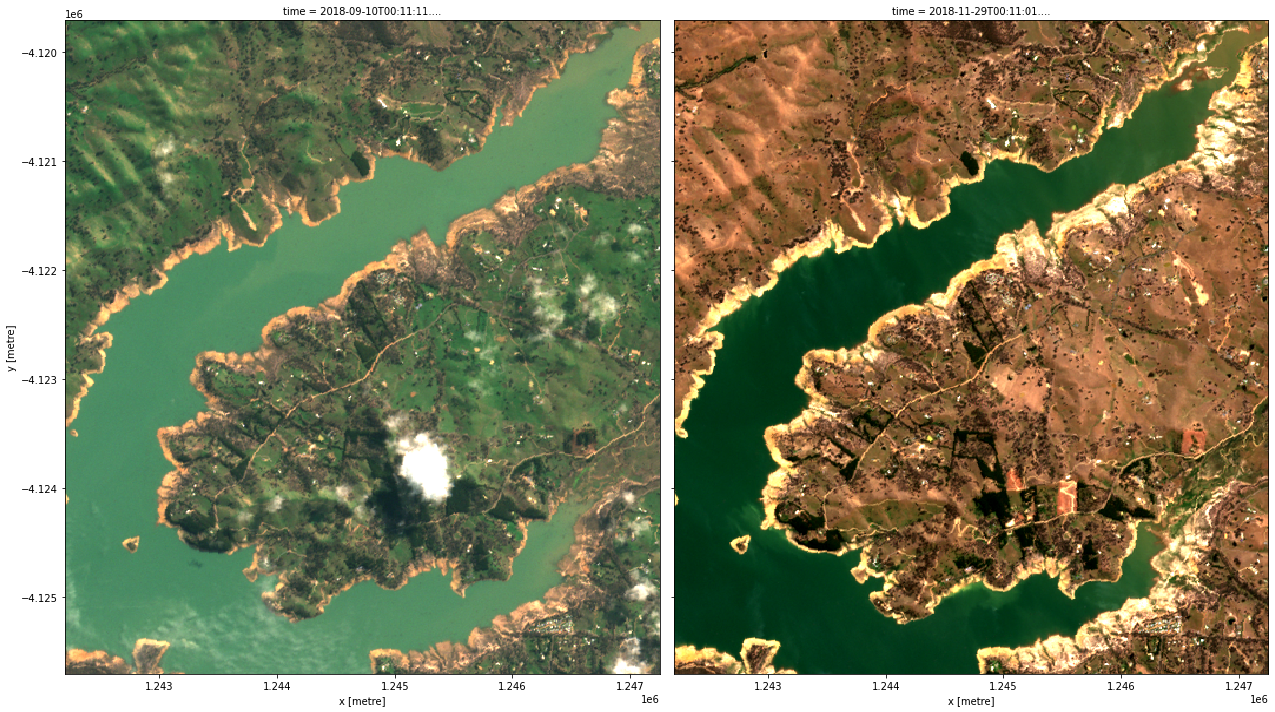

In [36]:
# Set the time step to view
time_step = [0,-1]

# Set the band combination to plot
bands = ["nbar_red", "nbar_green", "nbar_blue"]

# Generate the image by running the rgb function
rgb(dataset, bands=bands, index=time_step, size=10)

# Format the time stamp for use as the plot title
time_string = str(dataset.time.isel(time=time_step).values).split('.')[0]  

# Set the title and axis labels
ax = plt.gca()
ax.set_title(f"Timestep {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()


## Step 4: Calculate vegetation health

While it's possible to identify vegetation in the RGB image, it can be helpful to have a quantitative index to describe the health of vegetation directly. 

In this case, the [Normalised Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) can help identify areas of healthy vegetation.
For remote sensing data such as satellite imagery, it is defined as

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})}, \\
\end{aligned}
$$

where $\text{NIR}$ is the near-infrared band of the data, and $\text{Red}$ is the red band.
NDVI can take on values from -1 to 1; high values indicate healthy vegetation and negative values indicate non-vegetation (such as water). 

The following code calculates the top and bottom of the fraction separately, then computes the NDVI value directly from these components.
The calculated NDVI values are stored as their own data array.

In [37]:
# Calculate the components that make up the NDVI calculation
band_diff = dataset.nbar_nir_1 - dataset.nbar_red
band_sum = dataset.nbar_nir_1 + dataset.nbar_red

# Calculate NDVI and store it as a measurement in the original dataset
ndvi = band_diff / band_sum

After calculating the NDVI values, it is possible to plot them by adding the `.plot()` method to `ndvi` (the variable that the values are stored in).
The code below will plot a single image, based on the time selected with the `ndvi_time_step` variable.
Try changing this value to plot the NDVI map at different time steps.
Do you notice any differences?

> **Extension 1**: Sometimes, it is valuable to change the colour scale to something that helps with intuitively understanding the image.
For example, the "viridis" colour map shows high values in greens/yellows (mapping to vegetation), and low values in blue (mapping to water).
Try modifying the `.plot(cmap="RdYlGn")` command below to use `cmap="viridis"` instead.

> **Extension 2**: Below, a single time step is selected using the `.isel()` method.
It is possible to plot all time steps by removing the `.isel()` method, and modifying the `.plot()` method to be `.plot(col="time", col_wrap=3)`.
Plotting all of the time steps at once may make it easier to notice differences in vegetation over time.

<Figure size 720x720 with 0 Axes>

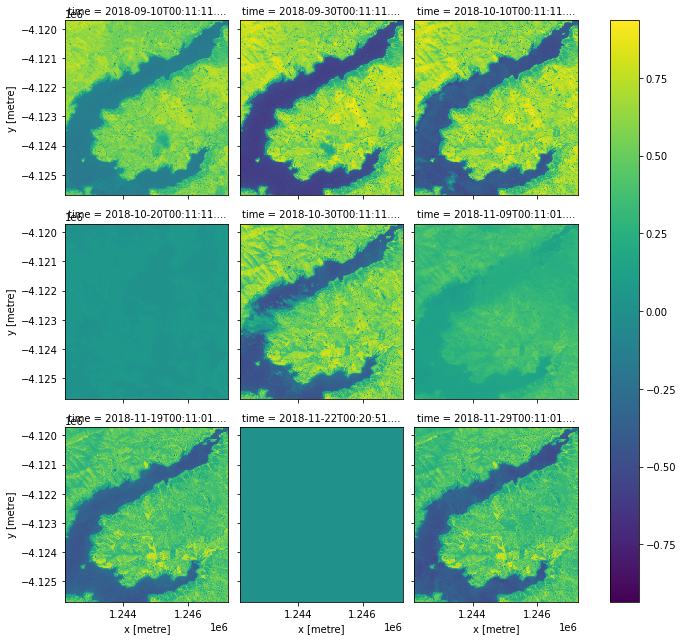

In [38]:
# Set the NDVI time step to view
ndvi_time_step = 0

# This is the simple way to plot
# Note that high values are likely to be vegetation.
plt.figure(figsize=(10, 10))
ndvi.plot(cmap="viridis", col = 'time', col_wrap = 3)
plt.show()

## Step 5: Exporting data

Sometimes, you will want to analyse satellite imagery in a GIS program, such as QGIS.
The `write_geotiff()` command from the Open Data Cube library allows loaded data to be exported to GeoTIFF, a commonly used file format for geospatial data.
> **Note**: the saved file will appear in the same directory as this notebook, and it can be downloaded from here for later use.

In [39]:
# You can change this, if you like.
filename = "example.tiff"

write_cog(geo_im=ndvi, fname=filename)

PosixPath('example.tiff')

## Recommended next steps

### For this notebook
Many of the variables used in this analysis are configurable.
We recommend returning to the beginning of the notebook and re-running the analysis with a different location, dates, measurements, and so on.
This will help give you more understanding for running your own analysis.
If you didn't try the extension activities the first time, try and work on these when you run through the notebook again.

### For other notebooks
To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](01_Jupyter_notebooks.ipynb)
2. [Digital Earth Australia](02_DEA.ipynb)
3. [Products and measurements](03_Products_and_measurements.ipynb)
4. [Loading data](04_Loading_data.ipynb)
5. [Plotting](05_Plotting.ipynb)
6. **Performing a basic analysis (this notebook)**
7. [Introduction to Numpy](07_Intro_to_numpy.ipynb)
8. [Introduction to Xarray](08_Intro_to_xarray.ipynb)
9. [Parallel processing with Dask](09_Parallel_processing_with_dask.ipynb)

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please review the FAQ section and support options on the [EY Data Science platform](https://datascience.ey.com/).